### Modelling

In [25]:
# Sampling libraries
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from Eda import *
from sklearn.utils import resample

# sklearn packages for Decision Tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 
from sklearn.metrics import roc_auc_score

# sklearn packages for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import StandardScaler

# sklearn packages for KNNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# sklearn packages for NN
from sklearn.neural_network import MLPClassifier

# Set print options
pd.set_option('display.max_columns', None)

from tqdm import tqdm

In [26]:
df = df[['address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'traveltime', 'famsup', 'famrel', 'G3']]

X = df.drop('G3', axis=1).values
y = df['G3'].values

In [27]:
def evaluate_model(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1).item()
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1).item()
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1).item()
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr').item()

    # Return the results
    return {
        'Model': model.__class__.__name__,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc_roc
    }

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_resampled, y_resampled = resample(X_train, y_train, replace=True, n_samples=20000, random_state=42)

#### Decision tree

In [29]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, test_size=0.2, random_state=32)
clf = DecisionTreeClassifier(criterion="entropy", max_depth=df.columns.size - 2)
clf.fit(X_train_i, y_train_i)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [8]:
# plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

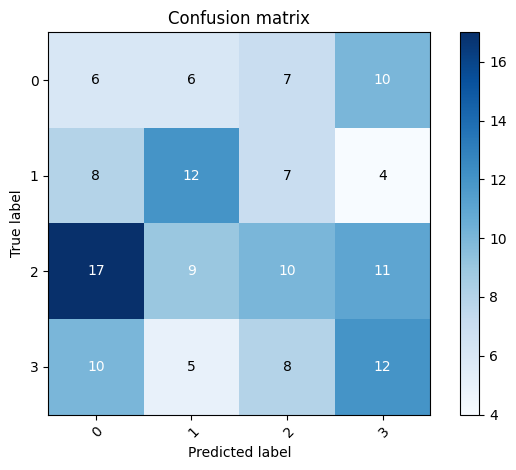

In [9]:
plot_confusion_matrix(y_test_i, clf.predict(X_test_i), classes=['0', '1', '2', '3'], normalize=False, title='Confusion matrix')
plt.show()

In [12]:
def plot_feature_importance(featImportLst):
    fig, ax = plt.subplots(ncols=1, figsize=(15, 5))
    fig.suptitle('Feature Importance for Different Dataframes')

    features = df[['address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'traveltime', 'famsup', 'famrel']].columns
    importances = featImportLst
    indices = np.argsort(importances)

    ax.barh(features[indices], importances[indices])
    ax.set(xlabel='Importance', ylabel='Feature', title='Feature Importance')

    fig.tight_layout()
    plt.show()

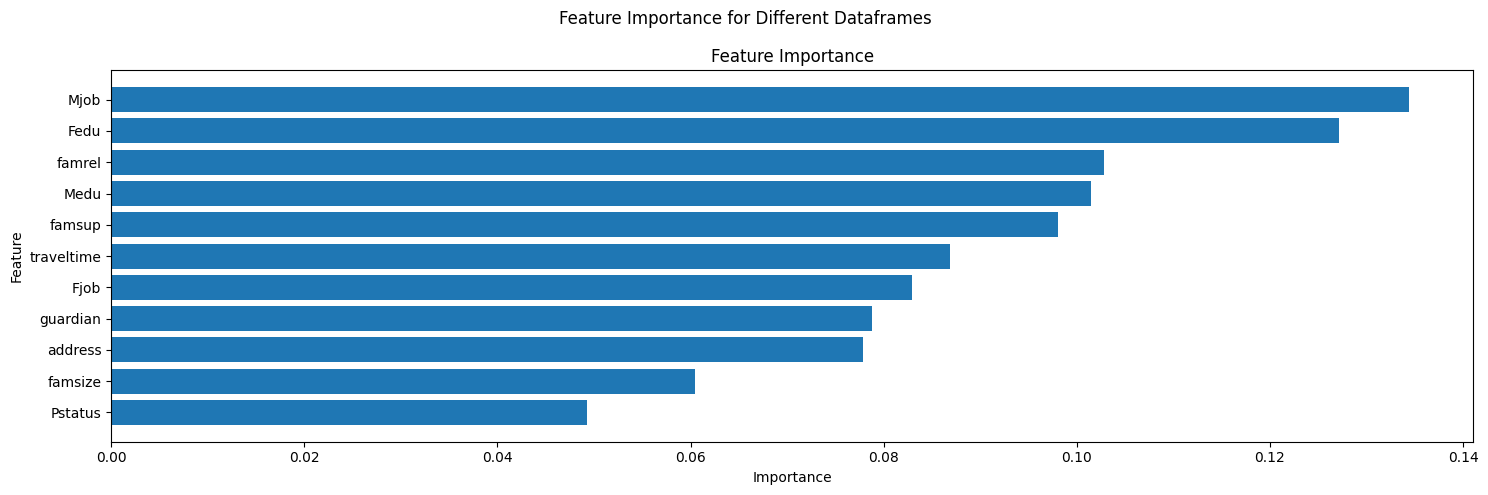

In [13]:
plot_feature_importance(clf.feature_importances_)

#### Random Forest

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
rf = RandomForestClassifier()

# fit and predict
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# evaluate the model
evaluate_model(rf, X_test, y_test)

{'Model': 'RandomForestClassifier',
 'Accuracy': 0.2887323943661972,
 'Precision': 0.29916384295908927,
 'Recall': 0.2887323943661972,
 'F1 Score': 0.29039830187303267,
 'AUC': 0.5212259207832931}

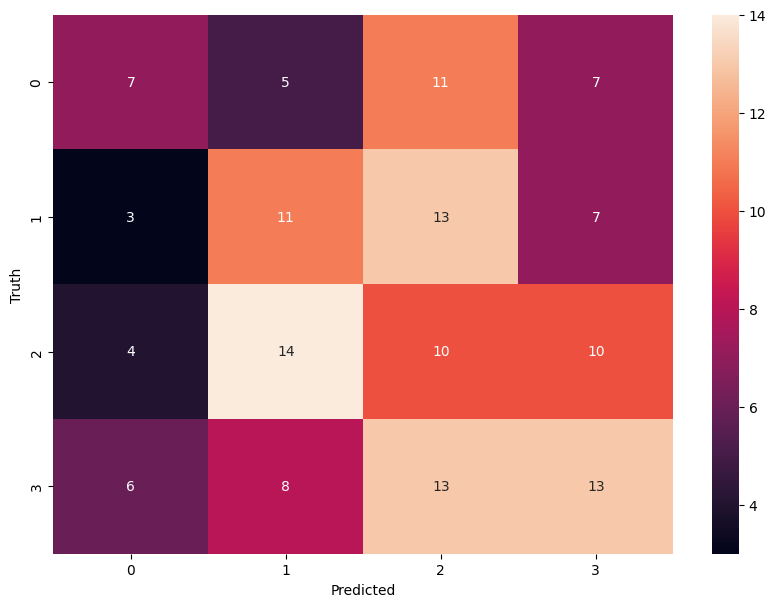

In [16]:
# plot a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

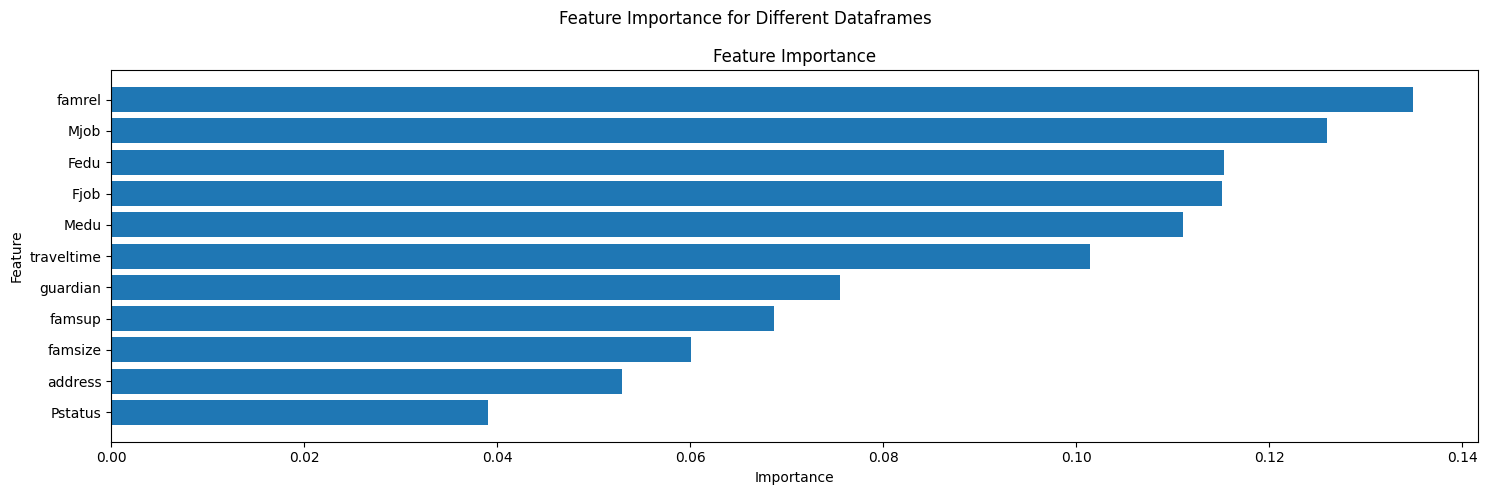

In [17]:
plot_feature_importance(rf.feature_importances_)


#### KNN

In [18]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')
scaler = StandardScaler()

scaler.fit(X_train_i)
X_train_std = scaler.transform(X_train_i)

knn.fit(X_train_std, y_train_i)

X_test_std = scaler.transform(X_test_i)

y_S_pred_2 = knn.predict(X_test_std)

evaluate_model(knn, X_test_i, y_test_i)

{'Model': 'KNeighborsClassifier',
 'Accuracy': 0.2535211267605634,
 'Precision': 0.2062896861689618,
 'Recall': 0.2535211267605634,
 'F1 Score': 0.22617666886548318,
 'AUC': 0.520041575587725}

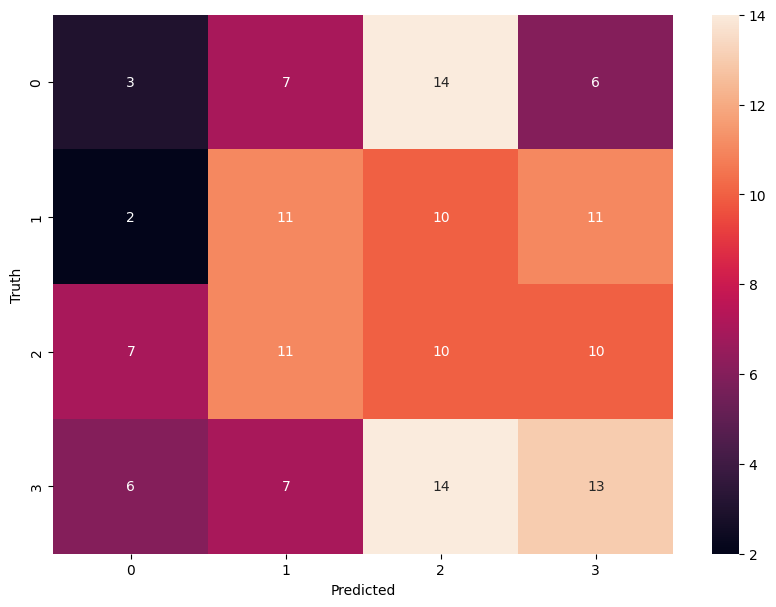

In [19]:
# plot a confusion matrix for KNN
cm = confusion_matrix(y_test_i, y_S_pred_2)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

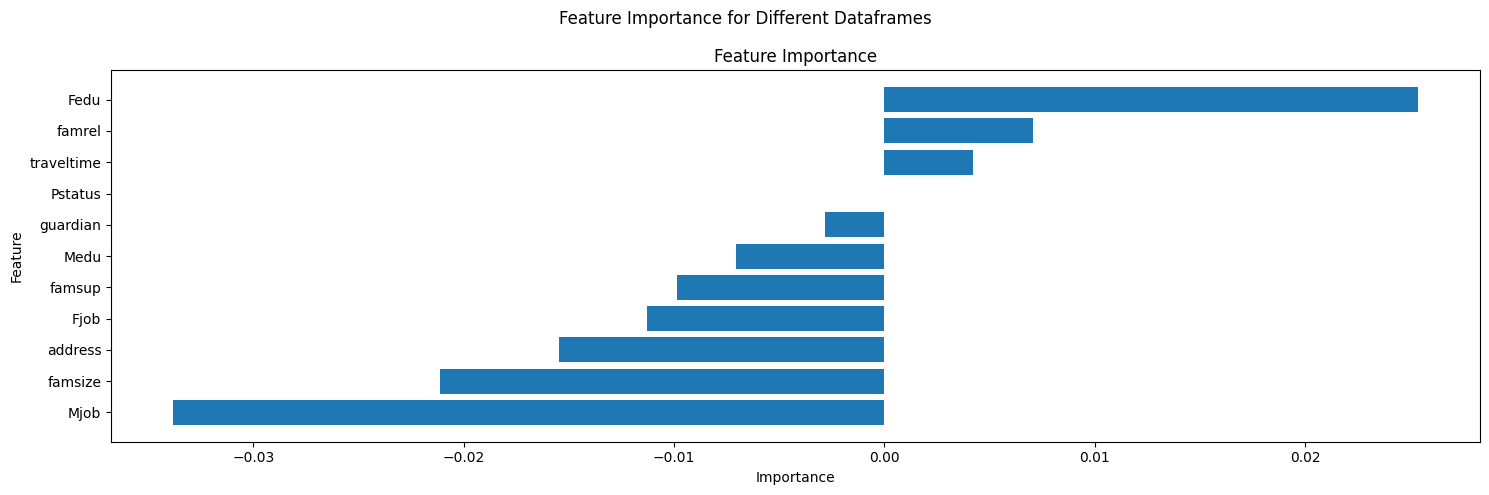

In [20]:
perm_importance = permutation_importance(knn, X_test_i, y_test_i, scoring='accuracy')
plot_feature_importance(perm_importance.importances_mean)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
nn = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=10000, activation='logistic', solver='lbfgs', learning_rate='adaptive')

nn.fit(X_train, y_train)
f = nn.predict(X_test)

print(nn.score(X_test, y_test))
print(nn.loss_)

0.2535211267605634
0.1213538503799893


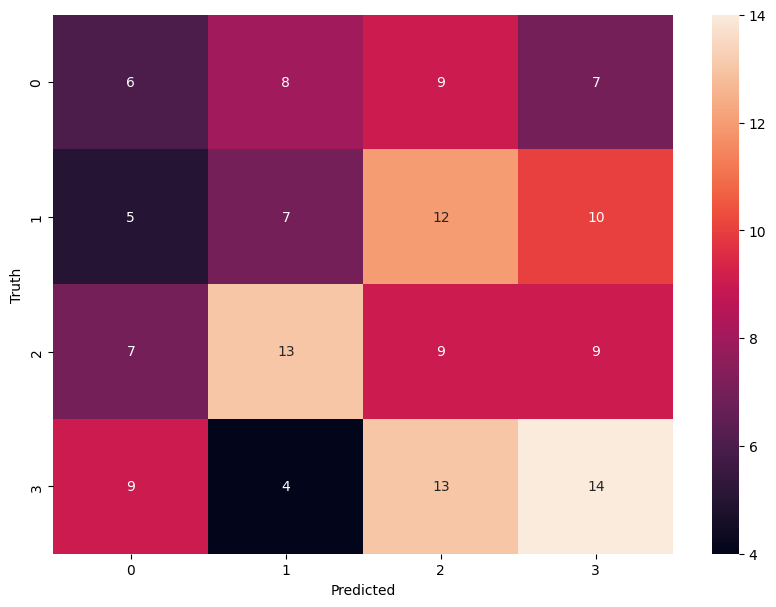

In [ ]:
# plot a confusion matrix for NN
cm = confusion_matrix(y_test, f)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


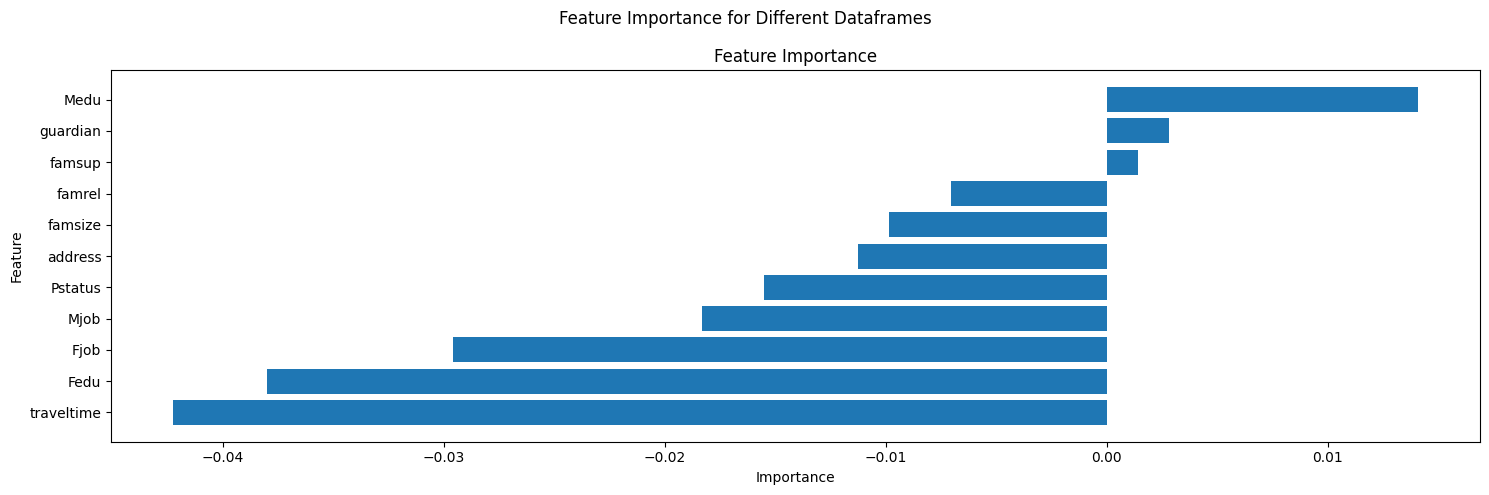

In [24]:
perm_importance = permutation_importance(nn, X_test, y_test, scoring='accuracy')
plot_feature_importance(perm_importance.importances_mean)

#### TODO:
1. Træn alle modeller på kønsfordelingen
2. Se importance features på de nye modeller
3. Vælg de vigtige features og træn modeller igen
4. NB: vigtige features kan også udvælges fra eda visualiseringerne.